In [ ]:
!wget https://bitbucket.org/ishaanjav/code-and-deploy-custom-tensorflow-lite-model/raw/a4febbfee178324b2083e322cdead7465d6fdf95/fruits.zip

--2024-05-06 11:01:29--  https://bitbucket.org/ishaanjav/code-and-deploy-custom-tensorflow-lite-model/raw/a4febbfee178324b2083e322cdead7465d6fdf95/fruits.zip
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c0:3470, 2406:da00:ff00::6b17:d1f5, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105946856 (101M) [application/zip]
Saving to: ‘fruits.zip’

fruits.zip          100%[===================>] 101.04M  48.3MB/s    in 2.1s    

2024-05-06 11:01:33 (48.3 MB/s) - ‘fruits.zip’ saved [105946856/105946856]



In [ ]:
!unzip fruits.zip

Archive:  fruits.zip
   creating: fruits/
  inflating: __MACOSX/._fruits       
  inflating: fruits/.DS_Store        
  inflating: __MACOSX/fruits/._.DS_Store  
   creating: fruits/test/
   creating: fruits/train/
   creating: fruits/validation/
   creating: fruits/test/apple/
  inflating: fruits/test/.DS_Store   
  inflating: __MACOSX/fruits/test/._.DS_Store  
   creating: fruits/test/banana/
   creating: fruits/test/orange/
   creating: fruits/train/apple/
  inflating: fruits/train/.DS_Store  
  inflating: __MACOSX/fruits/train/._.DS_Store  
   creating: fruits/train/banana/
   creating: fruits/train/orange/
   creating: fruits/validation/apple/
  inflating: fruits/validation/.DS_Store  
  inflating: __MACOSX/fruits/validation/._.DS_Store  
   creating: fruits/validation/banana/
   creating: fruits/validation/orange/
  inflating: fruits/test/apple/Screen Shot 2018-06-08 at 5.27.19 PM.png  
  inflating: __MACOSX/fruits/test/apple/._Screen Shot 2018-06-08 at 5.27.19 PM.png  
  inflatin

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
img_height, img_width = 32, 32
batch_size = 20

train_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/train",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/validation",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/test",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 460 files belonging to 3 classes.
Found 66 files belonging to 3 classes.
Found 130 files belonging to 3 classes.


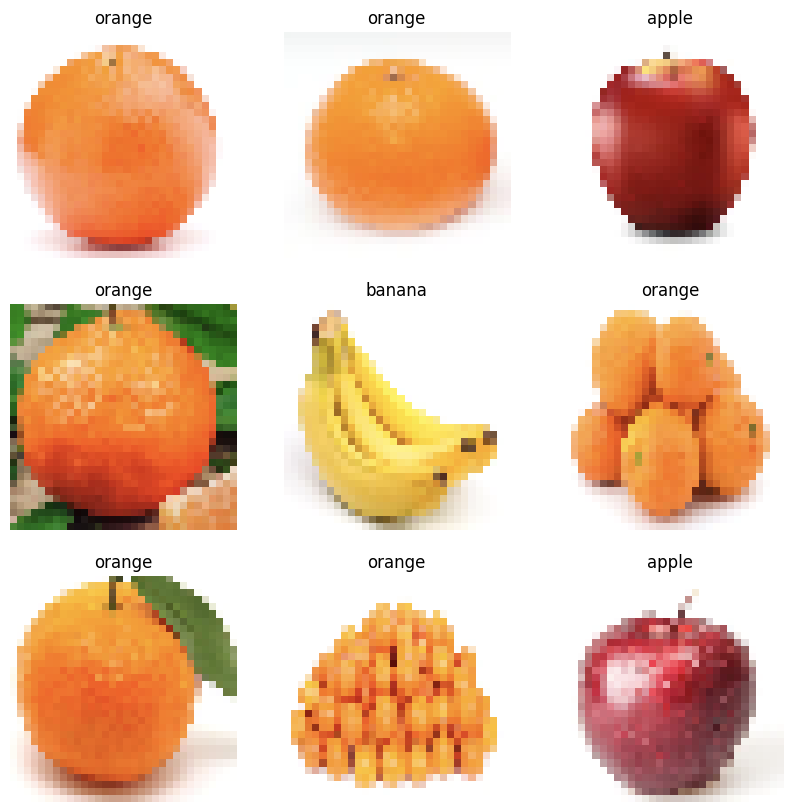

In [ ]:
class_names = ["apple", "banana", "orange"]
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
model = tf.keras.Sequential(
    [
     tf.keras.layers.Rescaling(1./255),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation="relu"),
     tf.keras.layers.Dense(3)
    ]
)


In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics=['accuracy']
)

In [ ]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10
)

Epoch 1/10
23/23 [==============================] - 2s 47ms/step - loss: 0.1276 - accuracy: 0.9609 - val_loss: 0.1857 - val_accuracy: 0.9545
Epoch 2/10
23/23 [==============================] - 2s 47ms/step - loss: 0.1001 - accuracy: 0.9761 - val_loss: 0.1859 - val_accuracy: 0.9394
Epoch 3/10
23/23 [==============================] - 2s 47ms/step - loss: 0.1066 - accuracy: 0.9696 - val_loss: 0.1063 - val_accuracy: 0.9545
Epoch 4/10
23/23 [==============================] - 2s 79ms/step - loss: 0.1074 - accuracy: 0.9761 - val_loss: 0.1150 - val_accuracy: 0.9545
Epoch 5/10
23/23 [==============================] - 2s 46ms/step - loss: 0.0665 - accuracy: 0.9804 - val_loss: 0.1144 - val_accuracy: 0.9545
Epoch 6/10
23/23 [==============================] - 2s 47ms/step - loss: 0.0723 - accuracy: 0.9761 - val_loss: 0.1401 - val_accuracy: 0.9394
Epoch 7/10
23/23 [==============================] - 2s 46ms/step - loss: 0.0705 - accuracy: 0.9783 - val_loss: 0.1604 - val_accuracy: 0.9394
Epoch 8/10
23

In [ ]:
model.evaluate(test_ds)

7/7 [==============================] - 0s 3ms/step - loss: 0.2478 - accuracy: 0.9462


[0.24777092039585114, 0.9461538195610046]

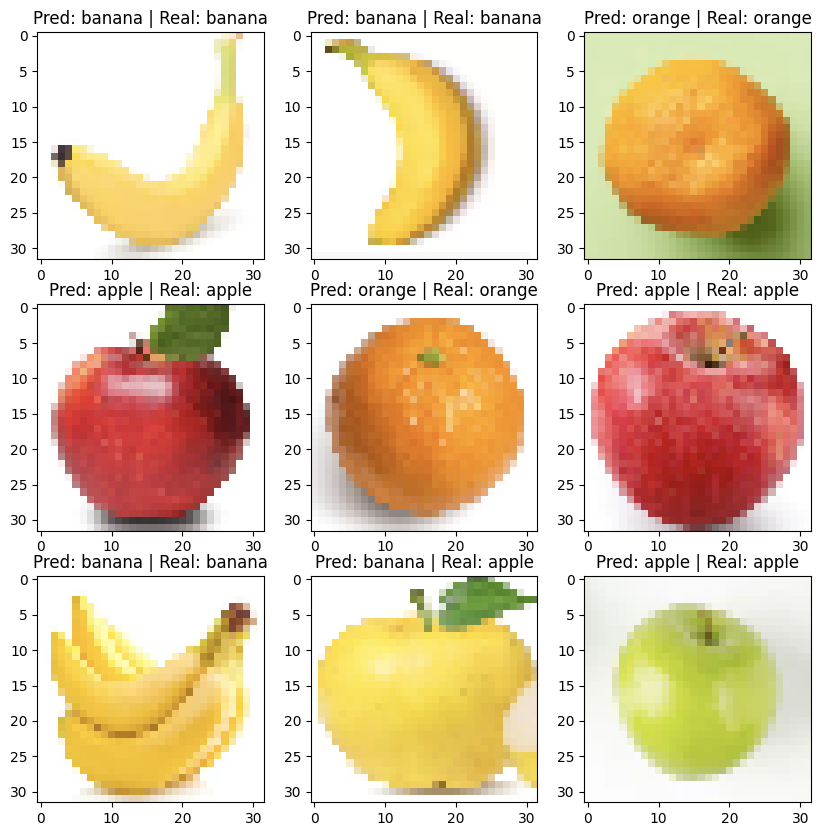

In [ ]:
import numpy

plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
  classifications = model(images)
  # print(classifications)

  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = numpy.argmax(classifications[i])
    plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]])

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp3w53j5c_/assets
